# TODOS:
1. Struktur: manuelle Frozenlake, Q-LEarning, Deep-Q-LEarning
2. report: umgebung beschreiben, modelle schreiben 

# Hands-on Project in RL for robotics: OpenAI' Gym - FrozenLake
- Member: Viet Duc Kieu, Anh Vu
- Matriculation no.: 9588548, 1039624

# 0 General introduction

## 0.1 Goals

The goal of the FrozenLake environment is for the agent to navigate from the starting position to the goal position on a frozen lake grid and to learn a policy that maximizes the total reward obtained while avoiding hazards.. The primary objective is for the agent to successfully reach the designated goal tile in the grid. The frozen lake is dotted with holes that the agent must avoid. If the agent falls into a hole, it fails and the episode ends. Moreovers, the ice in the FrozenLake environment can be slippery, causing the agent to slide in unintended directions. The agent needs to learn to deal with this uncertainty and make the appropriate moves.

## 0.2 Structure

## 0.3 Insprired Sources

- https://gymnasium.farama.org/content/basic_usage/: Basic Usage
- https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/#

# 1 Configuration

Installing some packages of gymnasium

In [1]:
! pip install gymnasium
! pip install gymnasium[toy-text]

You should consider upgrading via the 'c:\users\trang\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\trang\anaconda3\python.exe -m pip install --upgrade pip' command.


Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import numpy as np
from typing import NamedTuple
from pathlib import Path
import time

c:\Users\Trang\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# 1 Demonstrating a Basic Frozen Lake

## 1.1 Define Frozen Lake Environment 

In [3]:
# The FrozenLake environment
env = gym.make(
    "FrozenLake-v1",
    render_mode="human" # allow for human interaction and visualization
)

# Reset the environment to its initial state
env.reset()
# Render the environment
env.render()

In [4]:
# observation space-state: 4x4 space
env.observation_space 

Discrete(16)

In [5]:
# actions: left - 0, down - 1, right - 2, up - 3
env.action_space

Discrete(4)

In [6]:
# Generating random action
randomAction = env.action_space.sample()
returnValue = env.step(randomAction)
returnValue

(1, 0.0, False, False, {'prob': 0.3333333333333333})

Format of returnValue is (observation, reward, terminated, truncated, info)

- obeservation (object): observed state
- reward (float)
- terminated (bool): it is a terminal state
- truncated (bool)
- info (dictionary): transition probability

In [7]:
# Render the environment
env.render()

In [8]:
# perform deterministic step 0,1,2,3
returnValue = env.step(1)
returnValue

(5, 0.0, True, False, {'prob': 0.3333333333333333})

In [9]:
# reset the environment
env.reset()

(0, {'prob': 1})

In [10]:
# probability in state 5 and action 1
env.P[5][1]

[(1.0, 5, 0, True)]

## 1.2 Episode Generation

In [11]:
numberOfIterations = 30

In [12]:
for i in range(numberOfIterations):
    randomAction = env.action_space.sample()
    returnValue = env.step(randomAction)
    env.render()
    print("Iteration {} and action {}".format(i+1, randomAction))
    time.sleep(2)
    if returnValue[2]:
        break

env.reset()
env.close()

Iteration 1 and action 2
Iteration 2 and action 3
Iteration 3 and action 2
Iteration 4 and action 0
Iteration 5 and action 3


Iteration 6 and action 0
Iteration 7 and action 2
Iteration 8 and action 1
Iteration 9 and action 3
Iteration 10 and action 1
Iteration 11 and action 3
Iteration 12 and action 0
Iteration 13 and action 1
Iteration 14 and action 0
Iteration 15 and action 0
Iteration 16 and action 1
Iteration 17 and action 2


# 2 Frozen Lake using Q-Learning

## 2.1 Configurations

In [13]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting factor
    epsilon: float  # Exploration probability
    map_size: int  # Number of tiles of one side of the squared environment
    seed: int  # Define a seed so that we get reproducible results
    is_slippery: bool  # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    proba_frozen: float  # Probability that a tile is frozen
    savefig_folder: Path  # Root folder where plots are saved

In [14]:
# Define params
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=7,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("./static/img"),
)

In [15]:
# Set the seed
rng = np.random.default_rng(params.seed)

# Create the figure folder if it doesn't exists
params.savefig_folder.mkdir(parents=True, exist_ok=True)

## 2.2 Set up the FrozenLake environment with custom parameters

In [16]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

In [17]:
# Set the action size parameter of params to the number of possible actions in the environment
params = params._replace(action_size=env.action_space.n)
# Set the state size parameter of params to the number of possible states in the environment
params = params._replace(state_size=env.observation_space.n)

print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

Action size: 4
State size: 49


In [18]:
# Set the seed to get reproducible results when sampling the action space
env.action_space.seed(
    params.seed
)

[123]

## 2.3 Creating the Q-table

**Q-learning** is a type of reinforcement **learning algorithm** that aims to determine the optimal action to take based on the current state. It is classified as an "off-policy" algorithm because it learns from actions that are not necessarily guided by the current policy. In other words, it can learn from randomly selected actions instead of relying solely on the existing policy. The main objective of Q-learning is to learn a policy that maximizes the overall reward. <br/>
The "Q" in Q-learning stands for **quality**. Quality in this case represents how useful a given action is in gaining some future reward.

In [19]:
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        # Reset the Q-table
        # Initialize q-table values to 0
        self.qtable = np.zeros((self.state_size, self.action_size))

In [20]:
learner = Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)

## 2.4 Epsilon Greedy

**Epsilon Greedy** is used to decide which action to pick at each step. <br/>
Epsilon-Greedy is a simple method to balance **exploration** and **exploitation** by choosing between exploration and exploitation randomly. The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

<img src="./egreddy.PNG">

In [21]:
class EpsilonGreedy:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        """Choose an action `a` in the current world state (s)."""
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        # Exploration
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        else:
            # Break ties randomly
            # If all actions are the same for this state we choose a random one
            # (otherwise `np.argmax()` would always take the first one)
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()
            else:
                action = np.argmax(qtable[state, :])
        return action

In [22]:
explorer = EpsilonGreedy(
    epsilon=params.epsilon,
)

## 2.5 Running the environment

In [23]:
def run_env():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []

    for run in range(params.n_runs):  # Run several times to account for stochasticity
        learner.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{params.n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=params.seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = explorer.choose_action(
                    action_space=env.action_space, state=state, qtable=learner.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                learner.qtable[state, action] = learner.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = learner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

In [24]:
print(f"Map size: {params.map_size}x{params.map_size}")
rewards, steps, episodes, qtables, all_states, all_actions = run_env()

Run 0/20 - Episodes:   1%|          | 11/2000 [00:00<00:22, 89.42it/s]

Map size: 7x7


## 2.6 Visualization

In [25]:
def postprocess(episodes, params, rewards, steps, map_size):
    """Convert the results of the simulation in dataframes."""
    results = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    results["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    results["map_size"] = np.repeat(f"{map_size}x{map_size}", results.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return results, st

In [26]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [27]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [28]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

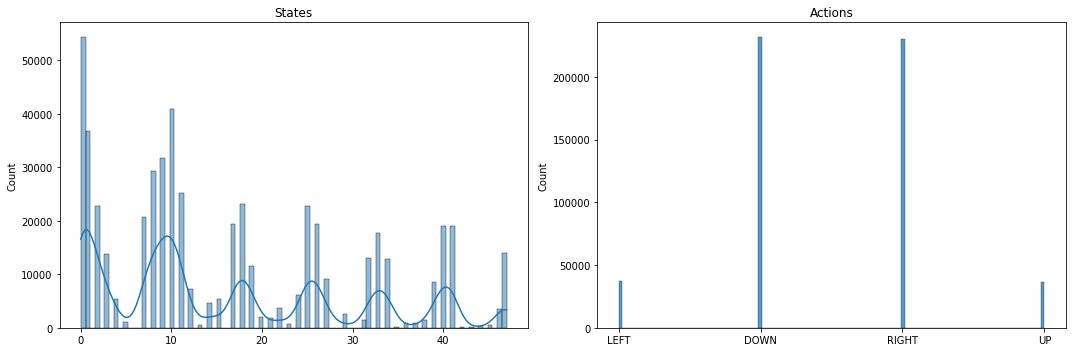

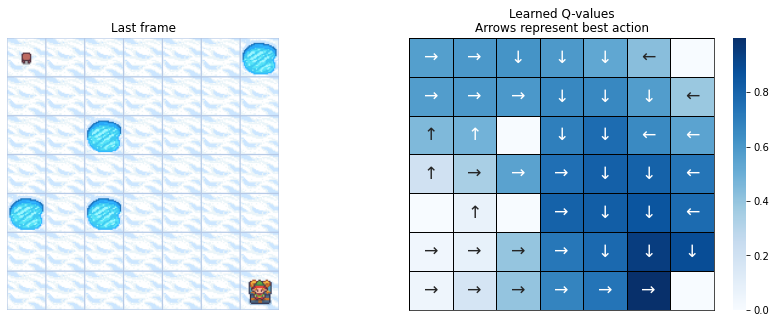

In [29]:
res_all = pd.DataFrame()
st_all = pd.DataFrame()

# Save the results in dataframes
res, st = postprocess(episodes, params, rewards, steps, params.map_size)
res_all = pd.concat([res_all, res])
st_all = pd.concat([st_all, st])
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

plot_states_actions_distribution(
    states=all_states, actions=all_actions, map_size=params.map_size
)  
# Sanity check
plot_q_values_map(qtable, env, params.map_size)

env.close()

The DOWN and RIGHT actions are frequently selected, which is logical considering that the agent begins at the top left of the map and needs to navigate towards the bottom right.

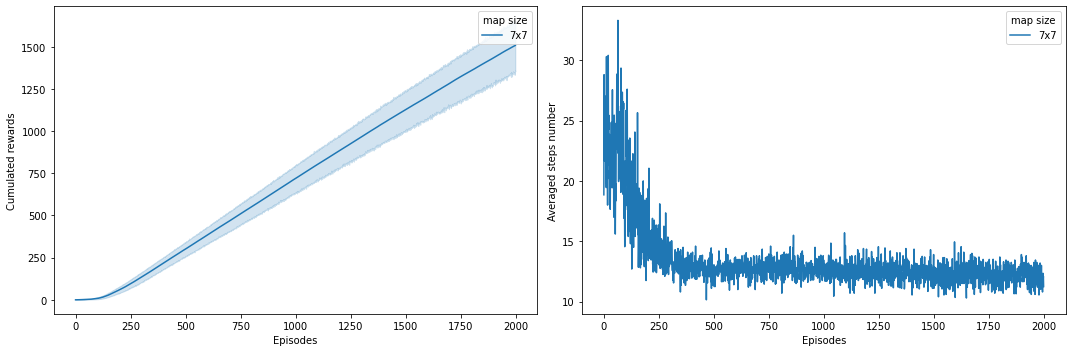

In [30]:
def plot_steps_and_rewards(rewards_df, steps_df):
    """Plot the steps and rewards from dataframes."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.lineplot(
        data=rewards_df, x="Episodes", y="cum_rewards", hue="map_size", ax=ax[0]
    )
    ax[0].set(ylabel="Cumulated rewards")

    sns.lineplot(data=steps_df, x="Episodes", y="Steps", hue="map_size", ax=ax[1])
    ax[1].set(ylabel="Averaged steps number")

    for axi in ax:
        axi.legend(title="map size")
    fig.tight_layout()
    img_title = "frozenlake_steps_and_rewards.png"
    fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()


plot_steps_and_rewards(res_all, st_all)